In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
from torchvision import transforms
from torchvision import datasets

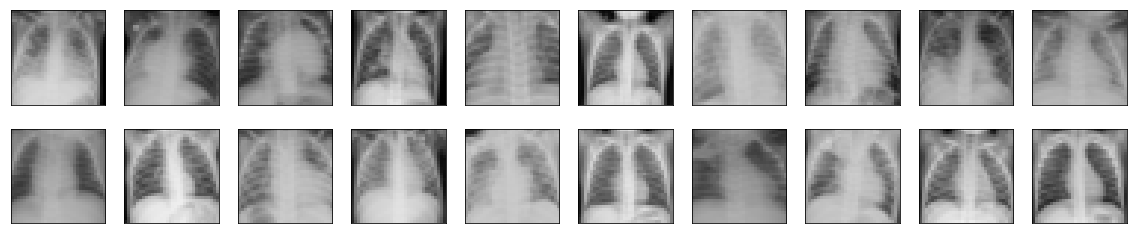

In [2]:
transforms_image = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor()])
train_xray = torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=transforms_image),
                                                        batch_size=20, shuffle=True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_xray)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [3]:
image_transforms = {'train': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
                  }

loaders = {'train': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=image_transforms['train']),
                                                        batch_size=128, shuffle=True),                    
                   'valid': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/val', 
                                                                             transform=image_transforms['valid']),
                                                        batch_size=128, shuffle=True), 
                   'test': torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/test', 
                                                                            transform=image_transforms['test']),
                                                        batch_size=128, shuffle=True)}

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(in_features=6272, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=412)
        self.fc4 = nn.Linear(in_features=412, out_features=133)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(F.max_pool2d(self.c1(x), 3))
        x = F.relu(F.max_pool2d(self.c2(x), 3))
        x = F.relu(F.max_pool2d(self.c3(x), 3))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


In [5]:
model = Net()

In [6]:
model.cuda()

Net(
  (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=412, bias=True)
  (fc4): Linear(in_features=412, out_features=133, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [8]:
for epoch in range(20):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    print('Epoch: ', epoch)
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['valid']):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    print('Validation accuracy: {:.0%}'.format(total_correct/total))
    if total_correct/total > 0.8:
        torch.save(model.state_dict(), 'pt/XRP_' + str(time.strftime("%Y%m%d_%H%M%S"))+'.pt')

Epoch:  0
Loss:  0.7229662537574768
Validation accuracy: 56%
Epoch:  1
Loss:  0.993748128414154
Validation accuracy: 62%
Epoch:  2
Loss:  0.9628987312316895
Validation accuracy: 75%
Epoch:  3
Loss:  0.5920718312263489
Validation accuracy: 81%
Epoch:  4
Loss:  0.7420121431350708
Validation accuracy: 81%
Epoch:  5
Loss:  0.826494574546814
Validation accuracy: 81%
Epoch:  6
Loss:  0.7263344526290894
Validation accuracy: 81%
Epoch:  7
Loss:  0.738873302936554
Validation accuracy: 75%
Epoch:  8
Loss:  0.9509673118591309
Validation accuracy: 69%
Epoch:  9
Loss:  0.6863226890563965
Validation accuracy: 81%
Epoch:  10
Loss:  1.1101726293563843
Validation accuracy: 62%
Epoch:  11
Loss:  1.0268611907958984
Validation accuracy: 69%
Epoch:  12
Loss:  0.5996370911598206
Validation accuracy: 75%
Epoch:  13
Loss:  1.1135540008544922
Validation accuracy: 69%
Epoch:  14
Loss:  0.7642762064933777
Validation accuracy: 75%
Epoch:  15
Loss:  0.668978750705719
Validation accuracy: 81%
Epoch:  16
Loss:  0.62